<a href="https://colab.research.google.com/github/adryduty/computer-vision-cat-project/blob/main/Copia_di_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load modules

In [1]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 12173, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12173 (delta 0), reused 2 (delta 0), pack-reused 12167
Receiving objects: 100% (12173/12173), 11.97 MiB | 32.68 MiB/s, done.
Resolving deltas: 100% (8427/8427), done.
/content/yolov5
     |████████████████████████████████| 596 kB 24.9 MB/s 
     |████████████████████████████████| 145 kB 29.0 MB/s 
     |████████████████████████████████| 178 kB 48.3 MB/s 
     |████████████████████████████████| 1.1 MB 46.3 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 138 kB 56.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io
import numpy as np    
from PIL import Image
import pickle
from google.colab import files, drive
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import time
import matplotlib.patches as patches
import tensorflow as tf
import pandas as pd
import os
import shutil
from math import floor
from sklearn.model_selection import train_test_split

# Here we are going to create some functions to take and save photos and to use them as input

### Almost all the lines of code there are here need to be run just one time (after that you just work with the pictures you saved).

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  '''
  This function creates a javascript function that takes a picture every 4000 milliseconds. 
  After that it displays the taken picture in the quality determined as argument, decode the picture in Base64 (binary) 
  and eventually returns the picture in binary.
  '''
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      
      // await new Promise(r => setTimeout(r, 1000));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  return binary

In [ ]:
def binary_to_numpy(binary):
  '''
  This function takes a picture coded in binary and transforms it as numpy array.
  '''
  img = Image.open(io.BytesIO(binary))
  # display(img)
  np_array = np.asarray(img)
  return np_array

In [ ]:
# drive.mount('/content/drive')

* Assign an empty list to photo_array (it will take the numpy arrays of the pictures);
* Decide how many pictures to take and assign this number to num_of_pictures_to_take;
* Iterate num_of_pictures_to_take times and every time append the taken picture (in numpy array) in the photo_array.
* If the user doesn't have a webcam or if he doesn't grant the page permission to access it, return an error.

In [ ]:
photo_array = []
num_of_pictures_to_take = 1

for i in range(num_of_pictures_to_take):
  try:
    binary = take_photo()
    photo_array.append(binary_to_numpy(binary))
    
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

<IPython.core.display.Javascript object>

In [ ]:
def show_image(np_array):
  '''
  This function takes a numpy array and displays the image relative to this numpy array.
  '''
  display(Image.fromarray(np_array))

In [ ]:
# Display all the images in photo_array.
for e in photo_array:
  show_image(e)

In [ ]:
len(photo_array)

In [ ]:
def save_in_local(sample_list, file_name):
  '''
  This function opens a file in the google colab and downloads it locally as pkl file (at the beginning
  the taken pictures where on colab and so we needed to save them locally. We decided to store them as pkl 
  to save some space but it wasn't so efficient)
  '''
  file_name = "/content/" + file_name + ".pkl"
  open_file = open(file_name, "wb")
  pickle.dump(sample_list, open_file)
  open_file.close()
  files.download(file_name)


def read_from_local(file_name):
  '''
  This function takes a file from colab (so you need to upload the file from the disk to colab) and loads it
  '''
  file_name = "/content/" + file_name + ".pkl"
  open_file = open(file_name, "rb")
  loaded_list = pickle.load(open_file)
  open_file.close()
  return loaded_list

In [ ]:
save_in_local(photo_array, "PELUCHE_LUCE3")

In [ ]:
lista = read_from_local("GHIRI_LUCE2")

# Labelling (bounding box)
### The idea is to create a 20x20 grid on the image to choose the rectangle around Ghiri (you just need to choose the upper left square and the bottom right square).
#### Notice that the considered images are resized to 416x416

In [ ]:
def label_maker(upper_left, bottom_right, n_cells):
  '''
  CONSIDER THAT YOU HAVE A 20x20 MATRIX AND THAT THE PIXELS ARE NORMALIZED TO 1 (they go from 0 to 1)

  This function takes the upper left and the bottom right squares as input and returns:
  - 0 (indicating the class: here is just 0 because we have just Ghiri)
  - X_c (X coordinate of the center of the bounding box)
  - Y_C (Y coordinate of the center of the bounding box)
  - Width of the bounding box
  - Height of the buonding box
  '''
  
  if (bottom_right % n_cells) < (upper_left % n_cells):
    print("Wrong input")
    
  elif (upper_left // n_cells) > (bottom_right // n_cells):
    print("Wrong input")

  else:
    num_squares_height = 1 + (bottom_right - upper_left) // n_cells
    height = num_squares_height / n_cells

    num_squares_width = 1 + (bottom_right - upper_left) % n_cells
    width = num_squares_width / n_cells 
    x_a = (upper_left % n_cells + 0.5) / n_cells
    y_a = (upper_left // n_cells + 0.5) / n_cells

    x_b = (bottom_right % n_cells + 0.5) / n_cells
    y_b = (bottom_right // n_cells + 0.5) / n_cells

    x_c = (x_a + x_b)/2
    y_c = (y_a + y_b)/2

    return 0, x_c, y_c, width, height 


In [ ]:
# This is a 10x10 grid for just understanding how the above function works
np.arange(10)+np.arange(0,100,10)[:,np.newaxis]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [ ]:
label_maker(15,43,10)

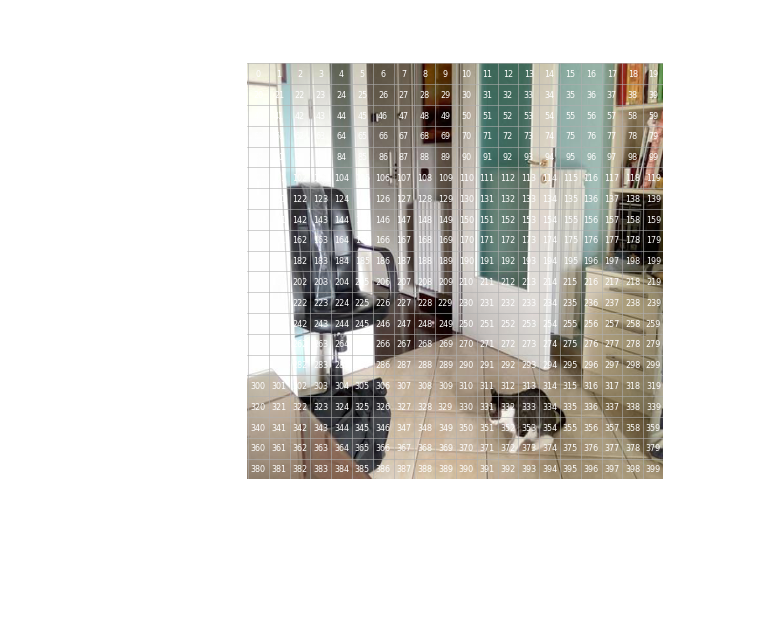

In [ ]:
def grid_image(google_path_image):
  '''
  This function takes as input the google path of the image you want to apply the grid onto.
  The output is the picture with the squares. 
  '''
  # Open image file
  img = Image.open(google_path_image)
  my_dpi=416.

  img = img.resize(size=(416, 416))

  # Set up figure
  fig=plt.figure(figsize=(float(img.size[0])/my_dpi,float(img.size[1])/my_dpi),dpi=my_dpi)
  ax=fig.add_subplot(111)

  # Remove whitespace from around the image
  fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

  # Set the gridding interval: here we use the major tick interval
  myInterval= 20.8
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  ax.tick_params(axis='x', colors=(0,0,0,0))
  ax.tick_params(axis='y', colors=(0,0,0,0))

  # Remove the borders 
  ax.spines['top'].set_visible(False) 
  ax.spines['right'].set_visible(False) 
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-', linewidth=0.1)

  # Add the image
  ax.imshow(img)

  # Find number of gridsquares in x and y direction
  nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
  ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))

  # Add some labels to the gridsquares
  for j in range(ny):
      y=myInterval/2+j * myInterval
      for i in range(nx):
          x=myInterval/2.+float(i) * myInterval
          ax.text(x,y,'{:d}'.format(i+j*nx),color='w',ha='center',va='center', fontsize=1.4)

  plt.show()

grid_image('/content/27GHIRI.jpg')

In [ ]:
# THIS IS JUST A CHUNK FOR UNDERSTANDING WHAT'S NEXT (DRAWING A RECTANGLE AROUND GHIRI)

im = Image.open('/content/27GHIRI.jpg')
im = im.resize(size=(416,416))

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((0.55*416, 0.75*416), 0.25*416, 0.2*416, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
def rectangle_coordinates(x_c, y_c, width, height):
  '''
  This function takes the coordinates of the rectangle's center and the width and the height of a
  rectangle and returns the coordinates of the rectangle's bottom left angle and the width and the height
  multiplied by 416. 
  
  These coordinates will be important to make the rectangle (see the rectangle_maker function)
  '''

  x_bottom_left_angle = (x_c - width/2)*416

  y_bottom_left_angle = (y_c - height/2)*416

  width = width * 416

  height = height * 416

  return x_bottom_left_angle, y_bottom_left_angle, width, height



In [ ]:
def rectangle_maker(google_path_image, x_c, y_c, width, height):

  '''
  This function takes a picture saved in colab, the coordinates of the centers of a rectangle, its width and its height.
  It returns the image with the rectangle around Ghiri and also saved it on colab
  '''

  im = Image.open(google_path_image)
  im = im.resize(size=(416,416))

  # Create figure and axes
  fig, ax = plt.subplots()
  
  x_left_angle, y_left_angle, denorm_width, denorm_height = rectangle_coordinates(x_c, y_c, width, height)
  
  # Create a Rectangle patch
  rect = patches.Rectangle((x_left_angle, y_left_angle), denorm_width, denorm_height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  ax.tick_params(axis='x', colors=(0,0,0,0))
  ax.tick_params(axis='y', colors=(0,0,0,0))

  # Remove the borders 
  ax.spines['top'].set_visible(False) 
  ax.spines['right'].set_visible(False) 
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  # Display the image
  ax.imshow(im)

  plt.savefig('/' + google_path_image.split("/")[1]+'/with_rectangle_'+google_path_image.split("/")[2])


In [ ]:
rectangle_maker('/content/27GHIRI.jpg', 0.6499999999999999, 0.8500000000000001, 0.25, 0.2)

### Let's create a list with all the names of the pictures saved on colab (by hand)

In [ ]:
path_list = []
numbers = ['00','01', '02', '03', '04','05','06','07','08','09',10,11,12,13,14,15,16,17,20,21,22,23,
             24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,'010','011','012','013','014','015','016','017',
             210,211,212,213,214,310,311,312,313]
for number in numbers:
  path_list.append("/content/" + str(number) + "GHIRI.jpg")

### The following chunk allows the user to insert the upper left and the bottom right squares to make the rectangles and so FOR LABELING. The labels will be stored into the **label_vector** list.

#### Each label will be an array **['google_path', 'label', 'x_c', 'y_c', 'width', 'height']**

In [ ]:
label_vector = []

for path in path_list:

  grid_image(path)

  time.sleep(3)

  upper_left = int(input("insert upper left square: "))

  bottom_right = int(input("insert bottom right square: "))
  
  label, x_c, y_c, width, height = label_maker(upper_left, bottom_right, 20)

  label_vector.append([path, label, x_c, y_c, width, height])

  rectangle_maker(path, x_c, y_c, width, height)

### Transform the label_vecor into a dataframe and store it as csv 

In [ ]:
label_dataframe = pd.DataFrame(label_vector, columns = ['google_path', 'label', 'x_c', 'y_c', 'width', 'height'])
label_dataframe.to_csv('/content/label_dataframe.csv', index = False )

# Augmentation and new labelling

### The idea is to apply to each of the 55 images, first just saturation augmentation, then just brightness augmentation and finally both together. Every time you need to upload the label vector and eventually you have to download as csv the data frame of the new label vector.

#### The final label vector will have 220 rows

In [ ]:
path_list = []
numbers = ['00','01', '02', '03', '04','05','06','07','08','09',10,11,12,13,14,15,16,17,20,21,22,23,
             24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,'010','011','012','013','014','015','016','017',
             210,211,212,213,214,310,311,312,313]
for number in numbers:
  path_list.append("/content/" + str(number) + "GHIRI.jpg")

In [ ]:
def sat_aug(original, saturation=0):
   s = tf.image.adjust_saturation(original, saturation)
   return s 

def brght_aug(original, brightness=0):
   b = tf.image.adjust_brightness(original, brightness)
   return b

### In the next chunk we apply the saturation augmentation to all the 55 images as numpy array and we store them in the arr_s_aug_list list

In [ ]:
arr_s_aug_list = []

for image_path in path_list:
  arr_img = np.asarray(Image.open(image_path))
  arr_img_s_aug = sat_aug(arr_img, saturation=5)
  arr_s_aug_list.append(arr_img_s_aug)

### Before running the following chunk, you need to create a s_aug directory inside the content directory. In this chunk we store the paths for the augmented images (with just saturation)

In [ ]:
path_list_s_aug = []
numbers = ['00','01', '02', '03', '04','05','06','07','08','09',10,11,12,13,14,15,16,17,20,21,22,23,
             24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,'010','011','012','013','014','015','016','017',
             210,211,212,213,214,310,311,312,313]
for number in numbers:
  path_list_s_aug.append("/content/s_aug/" + str(number) + "GHIRI_s_aug.jpg")

### In the next chunk we iterate for 55 times (the number of the new augmented images) and every time we take a path from path_list_s_aug (where all the new names are stored) and we save the array in image format in the specified path

In [ ]:
for element in range(len(path_list_s_aug)):
  path = path_list_s_aug[element]
  Image.fromarray(np.array(arr_s_aug_list[element])).save(path)

### The following two chunks create a zip of the pictures in the /content/s_aug path (the name of the zip is /content/s_aug.zip). The download the zip.

In [ ]:
!zip -r /content/s_aug.zip /content/s_aug

In [ ]:
files.download('/content/s_aug.zip')

### Let's now do the same for the augmentation with the brightness

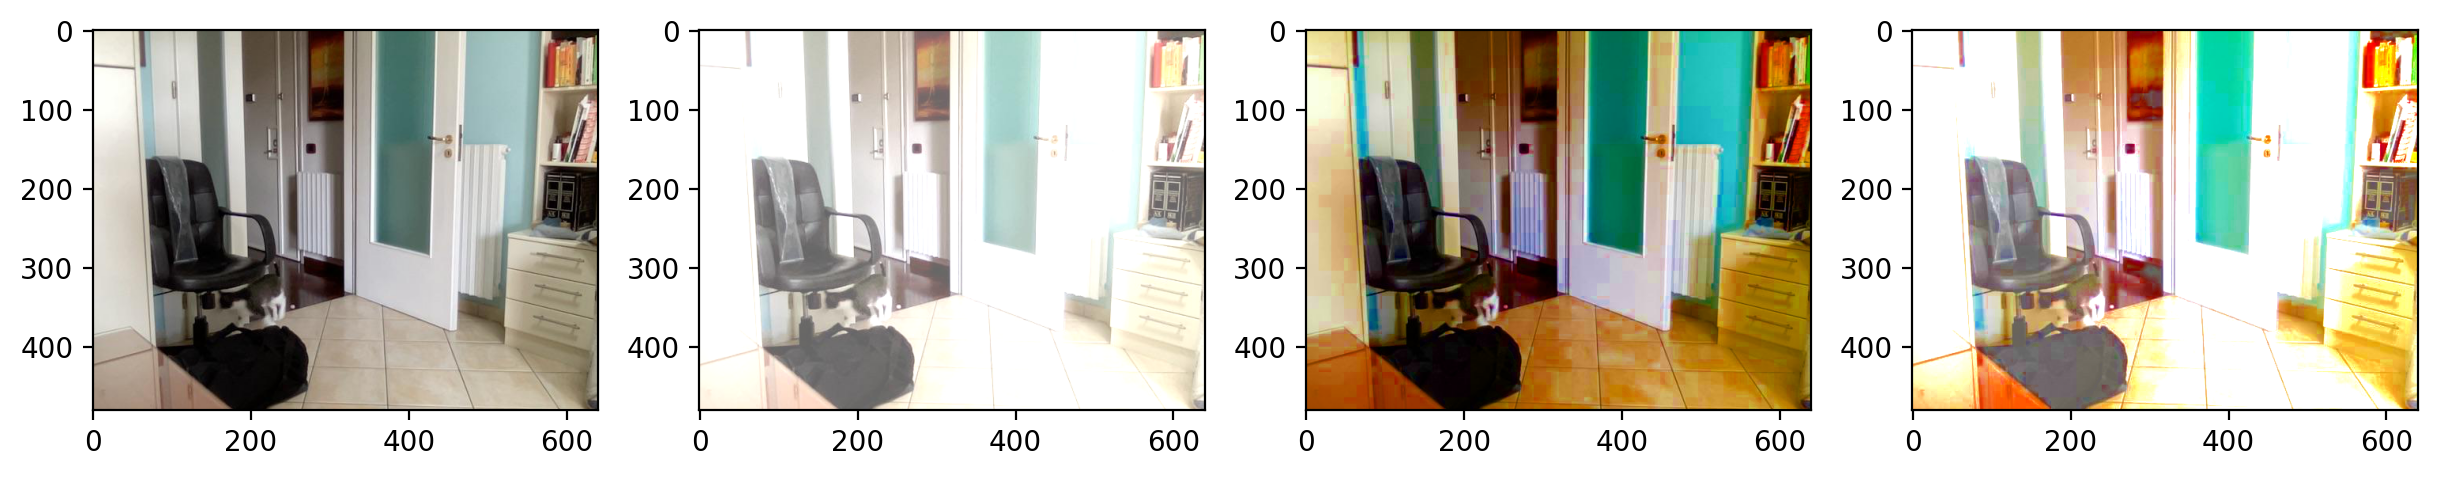

In [ ]:
my_image = np.asarray(Image.open('00GHIRI.jpg'))
plt.figure(figsize = (15,15), dpi = 200)
plt.subplot(1,4,1)
plt.imshow(my_image)
plt.subplot(1,4,2)
lala = brght_aug(my_image, brightness=0.4)
plt.imshow(lala)
plt.subplot(1,4,3)
plt.imshow(sat_aug(my_image, saturation = 5))
plt.subplot(1,4,4)
plt.imshow(sat_aug(lala, saturation=5))

In [ ]:
arr_b_aug_list = []

for image_path in path_list:
  arr_img = np.asarray(Image.open(image_path))
  arr_img_b_aug = brght_aug(arr_img, brightness=0.4)
  arr_b_aug_list.append(arr_img_b_aug)

In [ ]:
path_list_b_aug = []
numbers = ['00','01', '02', '03', '04','05','06','07','08','09',10,11,12,13,14,15,16,17,20,21,22,23,
             24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,'010','011','012','013','014','015','016','017',
             210,211,212,213,214,310,311,312,313]
for number in numbers:
  path_list_b_aug.append("/content/b_aug/" + str(number) + "GHIRI_b_aug.jpg")

In [ ]:
for element in range(len(path_list_b_aug)):
  path = path_list_b_aug[element]
  Image.fromarray(np.array(arr_b_aug_list[element])).save(path)

In [ ]:
!zip -r /content/b_aug.zip /content/b_aug

In [ ]:
files.download('/content/b_aug.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Let's complete the dataframe (df)

In [ ]:
google_path_bright = []
for element in path_list_b_aug:
  google_path_bright.append('/' + element.split('/')[1] + '/' + element.split('/')[-1])

In [ ]:
google_path_saturation = []
for element in path_list_s_aug:
  google_path_saturation.append('/' + element.split('/')[1] + '/' + element.split('/')[-1])

In [ ]:
google_path_tot = np.concatenate((np.array(df.iloc[:,0]), np.array(google_path_saturation), np.array(google_path_bright)))

In [ ]:
df_without_google_path = df.iloc[:, 1:].values
df_without_google_path = np.concatenate((df_without_google_path, df_without_google_path, df_without_google_path))

In [ ]:
df_google_path_tot = pd.DataFrame(google_path_tot, columns = ['google_path'])
df_without_google_path = pd.DataFrame(df_without_google_path, columns = [ 'label', 'x_c', 'y_c', 'width', 'height'])

In [ ]:
final_df = pd.concat([df_google_path_tot,df_without_google_path ], axis = 1)

In [ ]:
final_df.to_csv('/content/final_df.csv', index = False )

# Recreating all the directories of roboflow before applying the yolov5

### The following chunk creates empty folders

In [3]:
path = "/content/yolov5/Gatto-1"
os.mkdir(path)

path = "/content/yolov5/Gatto-1/test"
os.mkdir(path)
path = "/content/yolov5/Gatto-1/validation"
os.mkdir(path)
path = "/content/yolov5/Gatto-1/training"
os.mkdir(path)

path = "/content/yolov5/Gatto-1/test/images"
os.mkdir(path)
path = "/content/yolov5/Gatto-1/validation/images"
os.mkdir(path)
path = "/content/yolov5/Gatto-1/training/images"
os.mkdir(path)

path = "/content/yolov5/Gatto-1/test/labels"
os.mkdir(path)
path = "/content/yolov5/Gatto-1/validation/labels"
os.mkdir(path)
path = "/content/yolov5/Gatto-1/training/labels"
os.mkdir(path)

In [4]:
def file_path_changer(source, dest): 
  '''
  This function moves the files from the path 'source' to the path 'dest'
  '''
  shutil.move(source, dest)


In [5]:
df = pd.read_csv("/content/final_df.csv")

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 42)

validation, test = train_test_split(test, train_size = 0.66, test_size = 0.34, random_state = 42)

train_labels = train.iloc[:, 1:].values
valid_labels = validation.iloc[:, 1:].values
test_labels = test.iloc[:, 1:].values

train_im_list = list(train.iloc[:,0])
valid_im_list = list(validation.iloc[:, 0])
test_im_list = list(test.iloc[:, 0])

### The following chunk saves labels and image names in the proper folders (after having uploaded by hand)

In [7]:
for index in range(len(train_im_list)):
  file_name = "/content/yolov5/Gatto-1/training/labels/" + list(train_im_list)[index].split("/")[2].split(".")[0] + ".txt"
  f = open(file_name, "w")
  f.write(str(train_labels[index])[1:-1])
  f.close()


for index in range(len(valid_im_list)):
  file_name = "/content/yolov5/Gatto-1/validation/labels/" + list(train_im_list)[index].split("/")[2].split(".")[0] + ".txt"
  f = open(file_name, "w")
  f.write(str(train_labels[index])[1:-1])
  f.close()


for index in range(len(test_im_list)):
  file_name = "/content/yolov5/Gatto-1/test/labels/" + list(train_im_list)[index].split("/")[2].split(".")[0] + ".txt"
  f = open(file_name, "w")
  f.write(str(train_labels[index])[1:-1])
  f.close()



### Move the images from /content/imageName.jpg to the proper directory

In [8]:
for source in train_im_list:
  dest = "/content/yolov5/Gatto-1/training/images"
  file_path_changer(source, dest)

for source in valid_im_list:
  dest = "/content/yolov5/Gatto-1/validation/images"
  file_path_changer(source, dest)

for source in test_im_list:
  dest = "/content/yolov5/Gatto-1/test/images"
  file_path_changer(source, dest)

### The following chunk is for the yaml

In [9]:
data=open("/content/yolov5/Gatto-1/data.yaml", "w")
data.write("names:\n- Cat1\nnc: 1\ntrain: /content/yolov5/Gatto-1/training/images\nval: /content/yolov5/Gatto-1/validation/images\n")
data.close()

# Run the YOLOv5 (we used a yolov5s)

In [ ]:
!python train.py --img 416 --batch 16 --epochs 150 --data /content/yolov5/Gatto-1/data.yaml --weights yolov5s.pt --cache

### We use model = torch.hub.load(...) because in this way you can simply load the weights (best.pt or last.pt) instead of running every time the yolov5s.

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', 
                       path='/content/yolov5/runs/train/exp/weights/best.pt', force_reload=True)

# model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # This is pretrained (200000 pictures)

In [12]:
for filename in os.listdir('/content/yolov5/Gatto-1/test/images'):
  img = Image.open('/content/yolov5/Gatto-1/test/images/' + filename)
  results = model(img)
  results.save()

Saved 1 image to runs/detect/exp
Saved 1 image to runs/detect/exp2
Saved 1 image to runs/detect/exp3
Saved 1 image to runs/detect/exp4
Saved 1 image to runs/detect/exp5
Saved 1 image to runs/detect/exp6
Saved 1 image to runs/detect/exp7
Saved 1 image to runs/detect/exp8
Saved 1 image to runs/detect/exp9
Saved 1 image to runs/detect/exp10
Saved 1 image to runs/detect/exp11
Saved 1 image to runs/detect/exp12
Saved 1 image to runs/detect/exp13
Saved 1 image to runs/detect/exp14
Saved 1 image to runs/detect/exp15
Saved 1 image to runs/detect/exp16
Saved 1 image to runs/detect/exp17


In [ ]:
# USELESS
# !python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source /content/yolov5/Gatto-1/test/images

# Let's use the camera and the frozen weights to detect Ghiri

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.1)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])


    #small_img = cv2.resize(img, (416,416))
    #x = small_img.astype(float) #convertiamo tutto in float
    #x/=255.

    #x = x.reshape(1, 416, 416, 3)
    results = model(img)
    #results.print()
    results.save()
    #count += 1
    #print(f'Immage number {count}')

### You can also use this one. The light is less yellow but it's slower in taking the pictures.

In [ ]:
photo_array = []
num_of_pictures_to_take = 10

for i in range(num_of_pictures_to_take):
  try:
    binary = take_photo()
    img = Image.fromarray(binary_to_numpy(binary)).resize((416, 416))
    results = model(img)
    results.save()

  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))